In [1]:
import os
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import integrate, signal, stats, fftpack
import pingouin as pg

## The following is needed to export text correctly for Illustrator ##
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load Zap_Zip-log_exp to get metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [6]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [7]:
area_colors = {
    'MO': (31/255, 157/255, 90/255), # [31, 157, 90] 'blue'
    'ACA': (64/255, 166/255, 102/255), # [64, 166, 102] 'deepskyblue'
    'SS': (24/255, 128/255, 100/255), # [24, 128, 100] 'blueviolet'
    'VIS': (8/255, 133/255, 140/255), # [8, 133, 140] 'green'
    'MO-TH': (255/255, 112/255, 128/255), # [255, 112, 128] 'steelblue'
#     'VIS-TH': 'olivedrab'
}

In [8]:
# state_colors = {
#     'awake': (120/255, 156/255, 74/255),
#     'anesthetized': (130/255, 122/255, 163/255),
#     'recovery': (93/255, 167/255, 229/255)
# }
state_colors = {
    'stationary': 'royalblue',
    'moving': 'seagreen',
    'anesthetized': 'indianred',
}

#### Functions

In [9]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [10]:
def p_stars(test_pval):
    if test_pval < 0.001:
        return '***'
    elif test_pval < 0.01:
        return '**'
    elif test_pval < 0.05:
        return '*'
    else:
        return 'n.s.'

## Load subjects from file

In [11]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wrec.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [12]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial

 521885
Experiment type: electrical stimulation
 521886
Experiment type: electrical stimulation
 521887
Experiment type: electrical stimulation
 543393
Experiment type: electrical stimulation
 543394
Experiment type: electrical stimulation
 543396
Experiment type: electrical and sensory stimulation
 575102
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

MOs_deep

 546655
Experiment type: electrical and sensory stimulation
 551399
Experiment type: electrical stimulation
 551397
Experiment type: electrical and sensory stimulation
 569062
Experiment type: electrical and sensory stimulation
 569068
Experiment type: electrical and sensory stimulation
 569069
Experiment type: electrical and sensory stimulation
 569064
Experiment type: electrical and sensory stimulation
 569073
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation
 569070
Experiment type: electrical stimulation


In [13]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs\PCI'
# Gplotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GRC2022_poster'

## All subjects

In [14]:
## Parameters ##
test_states = ['awake', 'anesthetized', 'recovery1', 'recovery2']
apply_car = True
sigalpha = 0.01

In [15]:
all_subs_EEG_stats = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')

        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        try:
            bad_chs = mdata['bad_chs']
        except KeyError:
            badchstr = exp_meta['EEG bad_channels'].replace(' ','')
            bad_chs = []
            for char in badchstr.split(','):
                if char.isdecimal():
                    bad_chs.append(int(char))
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)
        if len(currents_list) > 1:
            PCI_stim_amp = currents_list[1]
        elif len(currents_list) == 1:
            PCI_stim_amp = currents_list[0]
        else:
            print('No stim current listed in Zap_Zip-log_exp')

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        
        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        mdata['good_chs'] = GOOD_CHS

        ## Get event inds ##
        all_event_inds = {}
        for statei in test_states:
            sweeps = mdata['states'][statei]
            if not sweeps:
                continue
            if statei == 'awake':
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', PCI_stim_amp, sweepi, trials='all')
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[statei] = np.concatenate(state_events)
                substates = ['resting', 'running']
                for substatei in substates:
                    state_events = []
                    for sweepi in sweeps:
                        events = get_stim_event_inds(stim_log, 'biphasic', PCI_stim_amp, sweepi, trials=substatei)
                        if len(events) == 0:
                            continue
                        state_events.append(events)
                    all_event_inds[substatei] = np.concatenate(state_events)
            else:
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', PCI_stim_amp, sweepi, trials='all')
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[statei] = np.concatenate(state_events)
        
        ## Get evoked traces ##
        start = time.time()
        EEG_traces = {}
        for statei, event_inds in all_event_inds.items():
            ## Get evoked EEG traces ##
            event_traces = all_EEG_traces[:, :, event_inds]
            if apply_car:
                event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
            EEG_traces[statei] = [EEG_event_timestamps, event_traces]
            
            all_subs_EEG_stats.append([
                group, mouse_num, stim_area, stim_depth, PCI_stim_amp, statei, len(event_inds), len(mdata['good_chs'])
            ])
        mdata['EEG_traces'] = EEG_traces        
        del stim_log, all_EEG_traces, EEG_event_timestamps
        end = time.time()
        print('  Time to get event EEG traces: {:.2f} s'.format(end-start))
    print('')
## Create stats dataframe ##
all_subs_EEG_stats_df = pd.DataFrame(all_subs_EEG_stats, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'stim_amp', 'state', 'trial_count', 'num_chs'
])

MOs_superficial
 521885
  Time to get event EEG traces: 1.74 s
 521886
  Time to get event EEG traces: 5.35 s
 521887
  Time to get event EEG traces: 13.01 s
 543393
  Time to get event EEG traces: 16.01 s
 543394
  Time to get event EEG traces: 16.91 s
 543396
  Time to get event EEG traces: 4.65 s
 575102
  Time to get event EEG traces: 9.50 s
 571619
  Time to get event EEG traces: 5.84 s

MOs_deep
 546655
  Time to get event EEG traces: 8.22 s
 551399
  Time to get event EEG traces: 9.92 s
 551397
  Time to get event EEG traces: 10.43 s
 569062
  Time to get event EEG traces: 8.47 s
 569068
  Time to get event EEG traces: 11.42 s
 569069
  Time to get event EEG traces: 11.02 s
 569064
  Time to get event EEG traces: 10.06 s
 569073
  Time to get event EEG traces: 9.73 s
 571619
  Time to get event EEG traces: 5.47 s
 569070
  Time to get event EEG traces: 5.67 s

SSp_superficial
 571620
  Time to get event EEG traces: 5.43 s
 586466
  Time to get event EEG traces: 5.38 s
 590479
  

In [16]:
all_subs_EEG_stats_df.head()

,group,mouse,stim_area,stim_depth,stim_amp,state,trial_count,num_chs
0,MOs_superficial,521885,MO,superficial,50,awake,60,17
1,MOs_superficial,521885,MO,superficial,50,resting,47,17
2,MOs_superficial,521885,MO,superficial,50,running,13,17
3,MOs_superficial,521885,MO,superficial,50,anesthetized,59,17
4,MOs_superficial,521886,MO,superficial,50,awake,99,20


In [17]:
awake_trials = all_subs_EEG_stats_df['trial_count'][all_subs_EEG_stats_df['state'] == 'awake'].values
print(len(awake_trials))
rest_trials = all_subs_EEG_stats_df['trial_count'][all_subs_EEG_stats_df['state'] == 'resting'].values
print(len(rest_trials))

31
31


In [18]:
np.mean(rest_trials/awake_trials)

0.7083756434113097

In [46]:
np.unique(all_subs_EEG_stats_df['mouse'].values)

array(['521885', '521886', '521887', '543393', '543394', '543396',
       '546655', '551397', '551399', '569062', '569064', '569068',
       '569069', '569070', '569072', '569073', '571619', '571620',
       '575102', '586466', '586468', '590479', '590480', '599017'],
      dtype=object)

## Calculate PCI: for different comparisons

In [19]:
PCI_params = {
    'baseline_window': (-0.8, -0.002), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.002, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}
trial_lim = 30

#### Awake vs. Anesthetized

In [20]:
comp_states = ['awake', 'anesthetized']

all_subs_PCI_stats = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        subdf = all_subs_EEG_stats_df[(all_subs_EEG_stats_df['group'] == group) & (all_subs_EEG_stats_df['mouse'] == mouse_num)]
        NUM_TRIALS = min([subdf['trial_count'][subdf['state'] == statei].values[0] for statei in comp_states])
        
        if NUM_TRIALS < trial_lim:
            print('Not enough trials, not computing PCI.\n')
            continue
        start = time.time()
        for statei in comp_states:
            state_traces = np.mean(mdata['EEG_traces'][statei][1][:, :, :NUM_TRIALS], axis=2)

            ## Calculate PCIst with full return ##
            full_PCI_output = calc_PCIst(
                state_traces[:, mdata['good_chs']].T,
                mdata['EEG_traces'][statei][0],
                full_return=True,
                **PCI_params
            )
            
            all_subs_PCI_stats.append([
                group, mouse_num, stim_area, stim_depth, PCI_stim_amp, statei, NUM_TRIALS, len(mdata['good_chs']),
                full_PCI_output['PCI'], full_PCI_output['n_dims']
            ])
            
            print('  {:s} PCI = {:.3f}'.format(statei, full_PCI_output['PCI']))
        end = time.time()
        print(' Time: {:.2f} s'.format(end-start))
        print('')
    print('')
## Create stats dataframe ##
awake_anest_PCI_df = pd.DataFrame(all_subs_PCI_stats, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'stim_amp', 'state', 'trial_count', 'num_chs', 'PCI', 'n_dims'
])

MOs_superficial
 521885
  awake PCI = 66.418
  anesthetized PCI = 19.204
 Time: 94.88 s

 521886
  awake PCI = 37.442
  anesthetized PCI = 7.729
 Time: 56.66 s

 521887
  awake PCI = 51.973
  anesthetized PCI = 8.380
 Time: 67.97 s

 543393
  awake PCI = 54.395
  anesthetized PCI = 7.645
 Time: 57.80 s

 543394
  awake PCI = 28.153
  anesthetized PCI = 13.922
 Time: 67.23 s

 543396
  awake PCI = 55.073
  anesthetized PCI = 7.942
 Time: 67.83 s

 575102
  awake PCI = 44.862
  anesthetized PCI = 32.150
 Time: 77.71 s

 571619
  awake PCI = 26.253
  anesthetized PCI = 17.407
 Time: 66.36 s


MOs_deep
 546655
  awake PCI = 58.696
  anesthetized PCI = 15.269
 Time: 77.23 s

 551399
  awake PCI = 42.142
  anesthetized PCI = 22.858
 Time: 77.72 s

 551397
  awake PCI = 77.456
  anesthetized PCI = 25.957
 Time: 100.90 s

 569062
  awake PCI = 58.159
  anesthetized PCI = 12.762
 Time: 65.85 s

 569068
  awake PCI = 22.596
  anesthetized PCI = 4.073
 Time: 32.97 s

 569069
  awake PCI = 59.345


In [22]:
awake_anest_PCI_df.head()

,group,mouse,stim_area,stim_depth,stim_amp,state,trial_count,num_chs,PCI,n_dims
0,MOs_superficial,521885,MO,superficial,50,awake,59,17,66.417644,5
1,MOs_superficial,521885,MO,superficial,50,anesthetized,59,17,19.203910,3
2,MOs_superficial,521886,MO,superficial,50,awake,99,20,37.442005,3
3,MOs_superficial,521886,MO,superficial,50,anesthetized,99,20,7.728822,2
4,MOs_superficial,521887,MO,superficial,50,awake,199,21,51.973333,4


In [23]:
## Normality tests ##
plstates = ['awake', 'anesthetized']
PCI_vals = []
for statei in plstates:
    stPCIvals = awake_anest_PCI_df['PCI'][awake_anest_PCI_df['state'] == statei].values
    PCI_vals.append(stPCIvals)
    print('{}: N={:d} mice'.format(statei, len(stPCIvals)))
    ## Shapiro-Wilk test ##
    swstat, swp = stats.shapiro(stPCIvals)
    if swp < sigalpha:
        print('  Shapiro-Wilk test: NOT normal')
    else:
        print('  Shapiro-Wilk test: normal')
        
    print(' mean={:.1f}, SEM={:.1f}\n'.format(np.mean(stPCIvals), np.std(stPCIvals)/np.sqrt(len(stPCIvals))))
PCI_vals = np.stack(PCI_vals)

awake: N=31 mice
  Shapiro-Wilk test: normal
 mean=45.5, SEM=3.6

anesthetized: N=31 mice
  Shapiro-Wilk test: NOT normal
 mean=16.5, SEM=2.4



The awake PCI values are normally distributed (3/4 tests), but the anesthetized values are not (0/4). This is most likely due to the outlier.

<IPython.core.display.Javascript object>


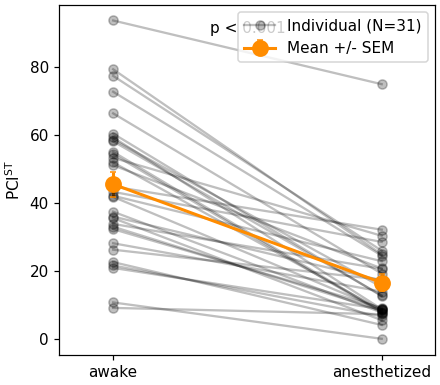

t = 10.260074924279621
p = 2.508E-11


In [24]:
fig, ax = plt.subplots(figsize=(4,3.5), constrained_layout=True)

individs = ax.plot([0, 1], PCI_vals, color='k', marker='o', alpha=0.25)
mean_sem = ax.errorbar(
    [0, 1], np.mean(PCI_vals, axis=1), yerr=stats.sem(PCI_vals, axis=1), color='darkorange',
    linewidth=2, marker='o', markersize=10
)
    
## Paired t-test ##
tstat, pval = stats.ttest_rel(PCI_vals[0,:], PCI_vals[1,:])
print("t = " + str(tstat))
print("p = {:.3E}".format(pval))

# annotate with asterisk
if pval < 0.001:
    ax.annotate('p < 0.001', xy=(0.5, 0.92), xycoords='axes fraction', ha='center') #, fontsize=11
else:
    ax.annotate('p = {:.1E}'.format(pval), xy=(0.5, 0.92), xycoords='axes fraction', ha='center')

ax.set_ylabel('$\mathregular{PCI^{ST}}$')#, fontsize=12)
ax.set_xlim([-0.2, 1.2])
ax.set_xticks([0, 1])
ax.set_xticklabels(plstates)
ax.legend([individs[0], mean_sem], [('Individual (N={:d})'.format(PCI_vals.shape[1])), 'Mean +/- SEM'])

# ax.annotate('N = {} mice'.format(len(dPCIs)), xy=(0.98, 0.98), xycoords='axes fraction', fontsize=11, ha='right', va='top')

#### Superficial vs. Deep

In [33]:
## Normality tests ##
compstate = 'awake'
compdepth = ['superficial', 'deep']
PCI_vals = []
for depi in compdepth:
    stPCIvals = awake_anest_PCI_df['PCI'][
        (awake_anest_PCI_df['state'] == compstate) & (awake_anest_PCI_df['stim_depth'] == depi)].values
    PCI_vals.append(stPCIvals)
    print('{}: N={:d} mice'.format(depi, len(stPCIvals)))
    ## Shapiro-Wilk test ##
    swstat, swp = stats.shapiro(stPCIvals)
    if swp < sigalpha:
        print('  Shapiro-Wilk test: NOT normal')
    else:
        print('  Shapiro-Wilk test: normal')
        
    print(' mean={:.1f}, SEM={:.1f}\n'.format(np.mean(stPCIvals), np.std(stPCIvals)/np.sqrt(len(stPCIvals))))
# PCI_vals = np.stack(PCI_vals)

sdtstat, sdpval = stats.ttest_ind(PCI_vals[0], PCI_vals[1])
print('Students t-test: pval={:.4f}'.format(sdpval))

superficial: N=13 mice
  Shapiro-Wilk test: normal
 mean=35.6, SEM=4.8

deep: N=18 mice
  Shapiro-Wilk test: normal
 mean=52.7, SEM=4.4

Students t-test: pval=0.0179


The superficial and deep PCI values are normally distributed (3/4 tests).

<IPython.core.display.Javascript object>


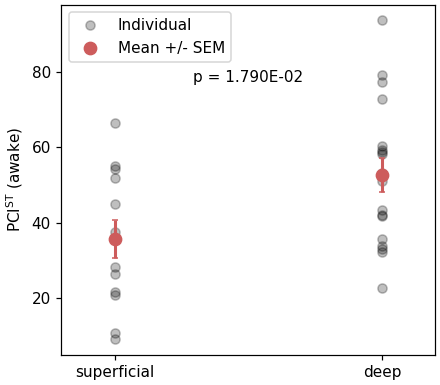

[Text(0, 0, 'superficial'), Text(1, 0, 'deep')]

In [34]:
fig, ax = plt.subplots(figsize=(4,3.5), constrained_layout=True)
delta = 0

for ii, (depi, vals) in enumerate(zip(compdepth, PCI_vals)):
    ax.scatter(np.repeat(ii, len(vals)), vals, color='k', marker='o', alpha=0.25)
    ax.errorbar([ii-delta], np.mean(vals), yerr=stats.sem(vals), color='indianred', linewidth=2, marker='o', markersize=8)

## Make legend ##
sdleg = [
    Line2D([0], [0], linestyle='none', c='k', marker='o', alpha=0.25, label='Individual'),
    Line2D([0], [0], linestyle='none', c='indianred', marker='o', markersize=8, label='Mean +/- SEM')
]
ax.legend(handles=sdleg)
    
## Stats annotation ##
if sdpval < 0.001:
    ax.annotate('p < 0.001', xy=(0.5, 0.78), xycoords='axes fraction', ha='center') #, fontsize=11
else:
    ax.annotate('p = {:.3E}'.format(sdpval), xy=(0.5, 0.78), xycoords='axes fraction', ha='center')

ax.set_ylabel('$\mathregular{PCI^{ST}}$ (awake)')#, fontsize=12)
ax.set_xlim([-0.2, 1.2])
ax.set_xticks([0, 1])
ax.set_xticklabels(compdepth)

#### Stationary vs. Moving vs. Anesthetized

In [28]:
comp_states = ['resting', 'running', 'anesthetized']

all_subs_PCI_stats = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        subdf = all_subs_EEG_stats_df[(all_subs_EEG_stats_df['group'] == group) & (all_subs_EEG_stats_df['mouse'] == mouse_num)]
        NUM_TRIALS = min([subdf['trial_count'][subdf['state'] == statei].values[0] for statei in comp_states])
        
        if NUM_TRIALS < trial_lim:
            print('Not enough trials, not computing PCI.\n')
            continue
        start = time.time()
        for statei in comp_states:
            state_traces = np.mean(mdata['EEG_traces'][statei][1][:, :, :NUM_TRIALS], axis=2)

            ## Calculate PCIst with full return ##
            full_PCI_output = calc_PCIst(
                state_traces[:, mdata['good_chs']].T,
                mdata['EEG_traces'][statei][0],
                full_return=True,
                **PCI_params
            )
            
            all_subs_PCI_stats.append([
                group, mouse_num, stim_area, stim_depth, PCI_stim_amp, statei, NUM_TRIALS, len(mdata['good_chs']),
                full_PCI_output['PCI'], full_PCI_output['n_dims']
            ])
            
            print('  {:s} PCI = {:.3f}'.format(statei, full_PCI_output['PCI']))
        end = time.time()
        print(' Time: {:.2f} s'.format(end-start))
        print('')
    print('')
## Create stats dataframe ##
stat_move_anest_PCI_df = pd.DataFrame(all_subs_PCI_stats, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'stim_amp', 'state', 'trial_count', 'num_chs', 'PCI', 'n_dims'
])

MOs_superficial
 521885
Not enough trials, not computing PCI.

 521886
Not enough trials, not computing PCI.

 521887
  resting PCI = 53.553
  running PCI = 30.522
  anesthetized PCI = 9.504
 Time: 100.69 s

 543393
  resting PCI = 36.813
  running PCI = 15.223
  anesthetized PCI = 0.000
 Time: 54.72 s

 543394
  resting PCI = 20.021
  running PCI = 27.656
  anesthetized PCI = 4.566
 Time: 65.00 s

 543396
Not enough trials, not computing PCI.

 575102
  resting PCI = 62.984
  running PCI = 32.685
  anesthetized PCI = 27.397
 Time: 122.29 s

 571619
Not enough trials, not computing PCI.


MOs_deep
 546655
  resting PCI = 66.297
  running PCI = 66.096
  anesthetized PCI = 10.684
 Time: 128.70 s

 551399
Not enough trials, not computing PCI.

 551397
Not enough trials, not computing PCI.

 569062
Not enough trials, not computing PCI.

 569068
Not enough trials, not computing PCI.

 569069
  resting PCI = 59.224
  running PCI = 42.131
  anesthetized PCI = 7.707
 Time: 117.49 s

 569064
No

In [29]:
subs_list = []
for index, row in stat_move_anest_PCI_df.iterrows():
    subs_list.append(row.mouse + '_' + row.group)
stat_move_anest_PCI_df['subject'] = subs_list
stat_move_anest_PCI_df.head()

,group,mouse,stim_area,stim_depth,stim_amp,state,trial_count,num_chs,PCI,n_dims,subject
0,MOs_superficial,521887,MO,superficial,50,resting,51,21,53.552682,4,521887_MOs_superficial
1,MOs_superficial,521887,MO,superficial,50,running,51,21,30.521604,3,521887_MOs_superficial
2,MOs_superficial,521887,MO,superficial,50,anesthetized,51,21,9.503659,2,521887_MOs_superficial
3,MOs_superficial,543393,MO,superficial,50,resting,54,24,36.812531,3,543393_MOs_superficial
4,MOs_superficial,543393,MO,superficial,50,running,54,24,15.222957,2,543393_MOs_superficial


In [35]:
trial_counts = stat_move_anest_PCI_df['trial_count'][stat_move_anest_PCI_df['state'] == 'resting'].values
print(len(trial_counts))
print(np.mean(trial_counts))
print(np.min(trial_counts))
print(np.max(trial_counts))

8
51.375
35
108


In [36]:
## Normality tests ##
plstates = ['resting', 'running', 'anesthetized']
PCI_vals = []
for statei in plstates:
    stPCIvals = stat_move_anest_PCI_df['PCI'][stat_move_anest_PCI_df['state'] == statei].values
    PCI_vals.append(stPCIvals)
    print('{}: N={:d} mice'.format(statei, len(stPCIvals)))
    ## Shapiro-Wilk test ##
    swstat, swp = stats.shapiro(stPCIvals)
    if swp < sigalpha:
        print('  Shapiro-Wilk test: NOT normal')
    else:
        print('  Shapiro-Wilk test: normal')
        
    print(' mean={:.1f}, SEM={:.1f}\n'.format(np.mean(stPCIvals), np.std(stPCIvals)/np.sqrt(len(stPCIvals))))

PCI_vals = np.stack(PCI_vals)

resting: N=8 mice
  Shapiro-Wilk test: normal
 mean=55.2, SEM=10.3

running: N=8 mice
  Shapiro-Wilk test: normal
 mean=39.9, SEM=7.7

anesthetized: N=8 mice
  Shapiro-Wilk test: normal
 mean=14.0, SEM=5.8



In [37]:
st_mov_ANOVA = pg.rm_anova(data=stat_move_anest_PCI_df, dv='PCI', within='state', subject='subject', detailed=True)

In [38]:
st_mov_ANOVA

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,state,6936.458267,2,3468.229133,28.314356,0.000012,0.352701,0.980909
1,Error,1714.861818,14,122.490130,NaN,NaN,NaN,NaN


In [42]:
print('resting-running-anest PCI ANOVA p-val = {:.3E}'.format(st_mov_ANOVA['p-unc'].values[0]))

resting-running-anest PCI ANOVA p-val = 1.202E-05


In [40]:
if st_mov_ANOVA['p-unc'].values[0] < sigalpha:
    print('There is a significant effect of state on PCI, now perform posthoc tests.')
    st_mov_posthoc = pg.pairwise_tests(
        data=stat_move_anest_PCI_df, dv='PCI', within='state', subject='subject', padjust='fdr_bh')
#     print(st_mov_posthoc)

There is a significant effect of state on PCI, now perform posthoc tests.


In [41]:
st_mov_posthoc

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,state,anesthetized,resting,True,True,-6.979580,7.0,two-sided,0.000215,0.000646,fdr_bh,145.087,-1.542625
1,state,anesthetized,running,True,True,-4.909302,7.0,two-sided,0.001735,0.002602,fdr_bh,26.383,-1.183484
2,state,resting,running,True,True,2.827921,7.0,two-sided,0.025482,0.025482,fdr_bh,3.161,0.526437


<IPython.core.display.Javascript object>


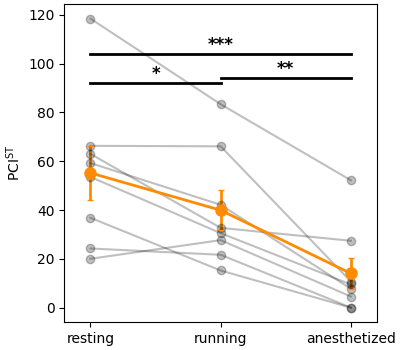

[Text(0, 0, 'resting'), Text(1, 0, 'running'), Text(2, 0, 'anesthetized')]

In [34]:
fig, ax = plt.subplots(figsize=(4, 3.5), constrained_layout=True)

individs = ax.plot([0, 1, 2], PCI_vals, color='k', marker='o', alpha=0.25)
mean_sem = ax.errorbar(
    [0, 1, 2], np.mean(PCI_vals, axis=1), yerr=stats.sem(PCI_vals, axis=1), color='darkorange',
    linewidth=2, marker='o', markersize=8
)

## annotate with stats asterisk
ax.plot([0,1], [92,92], color='k', linewidth=2)
ax.annotate('*', xy=(0.5,92), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
ax.plot([1,2], [94,94], color='k', linewidth=2)
ax.annotate('**', xy=(1.5,94), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
ax.plot([0,2], [104,104], color='k', linewidth=2)
ax.annotate('***', xy=(1,104), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')

ax.set_ylabel('$\mathregular{PCI^{ST}}$')#, fontsize=12)
ax.set_xlim([-0.2, 2.2])
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(plstates)

#### Awake vs. Anesthetized vs. Recovery 1&2

In [43]:
comp_states = ['awake', 'anesthetized', 'recovery1', 'recovery2']

all_subs_PCI_stats = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        subdf = all_subs_EEG_stats_df[(all_subs_EEG_stats_df['group'] == group) & (all_subs_EEG_stats_df['mouse'] == mouse_num)]
        if 'recovery1' not in subdf['state'].values:
            print(' No recovery period, not computing PCI.\n')
            continue
        if 'recovery2' not in subdf['state'].values:
            NUM_TRIALS = min(
                [subdf['trial_count'][subdf['state'] == statei].values[0] for statei in ['awake', 'anesthetized', 'recovery1']])
        else:
            NUM_TRIALS = min([subdf['trial_count'][subdf['state'] == statei].values[0] for statei in comp_states])
        
        if NUM_TRIALS < trial_lim:
            print(' Not enough trials, not computing PCI.\n')
            continue
        start = time.time()
        for statei in comp_states:
            if statei not in mdata['EEG_traces'].keys():
                print('  No {} period.'.format(statei))
                continue
            state_traces = np.mean(mdata['EEG_traces'][statei][1][:, :, :NUM_TRIALS], axis=2)

            ## Calculate PCIst with full return ##
            full_PCI_output = calc_PCIst(
                state_traces[:, mdata['good_chs']].T,
                mdata['EEG_traces'][statei][0],
                full_return=True,
                **PCI_params
            )
            
            all_subs_PCI_stats.append([
                group, mouse_num, stim_area, stim_depth, PCI_stim_amp, statei, NUM_TRIALS, len(mdata['good_chs']),
                full_PCI_output['PCI'], full_PCI_output['n_dims']
            ])
            
            print('  {:s} PCI = {:.3f}'.format(statei, full_PCI_output['PCI']))
        end = time.time()
        print(' Time: {:.2f} s'.format(end-start))
        print('')
    print('')
## Create stats dataframe ##
recovery_PCI_df = pd.DataFrame(all_subs_PCI_stats, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'stim_amp', 'state', 'trial_count', 'num_chs', 'PCI', 'n_dims'
])

MOs_superficial
 521885
 No recovery period, not computing PCI.

 521886
  awake PCI = 37.333
  anesthetized PCI = 7.891
  recovery1 PCI = 16.273
  No recovery2 period.
 Time: 80.11 s

 521887
  awake PCI = 51.973
  anesthetized PCI = 8.380
  recovery1 PCI = 58.294
  No recovery2 period.
 Time: 113.31 s

 543393
  awake PCI = 54.395
  anesthetized PCI = 7.645
  recovery1 PCI = 4.336
  No recovery2 period.
 Time: 68.62 s

 543394
  awake PCI = 27.577
  anesthetized PCI = 13.926
  recovery1 PCI = 9.457
  No recovery2 period.
 Time: 88.97 s

 543396
  awake PCI = 55.073
  anesthetized PCI = 7.942
  recovery1 PCI = 11.530
  No recovery2 period.
 Time: 90.11 s

 575102
  awake PCI = 44.862
  anesthetized PCI = 32.150
  recovery1 PCI = 37.023
  recovery2 PCI = 42.434
 Time: 172.33 s

 571619
 No recovery period, not computing PCI.


MOs_deep
 546655
 Not enough trials, not computing PCI.

 551399
  awake PCI = 42.142
  anesthetized PCI = 22.858
  recovery1 PCI = 40.002
  recovery2 PCI = 44.9

In [48]:
subs_list = []
for index, row in recovery_PCI_df.iterrows():
    subs_list.append(row.mouse + '_' + row.group)
recovery_PCI_df['subject'] = subs_list

In [49]:
recovery_PCI_df.head()

,group,mouse,stim_area,stim_depth,stim_amp,state,trial_count,num_chs,PCI,n_dims,subject
0,MOs_superficial,521886,MO,superficial,50,awake,98,20,37.333333,3,521886_MOs_superficial
1,MOs_superficial,521886,MO,superficial,50,anesthetized,98,20,7.890827,2,521886_MOs_superficial
2,MOs_superficial,521886,MO,superficial,50,recovery1,98,20,16.272982,2,521886_MOs_superficial
3,MOs_superficial,521887,MO,superficial,50,awake,199,21,51.973333,4,521887_MOs_superficial
4,MOs_superficial,521887,MO,superficial,50,anesthetized,199,21,8.379649,2,521887_MOs_superficial


In [50]:
## Normality tests ##
plstates = ['awake', 'anesthetized', 'recovery1', 'recovery2']
PCI_vals = []
for statei in plstates:
    stPCIvals = recovery_PCI_df['PCI'][recovery_PCI_df['state'] == statei].values
    PCI_vals.append(stPCIvals)
    print('{}: N={:d} mice'.format(statei, len(stPCIvals)))
    ## Shapiro-Wilk test ##
    swstat, swp = stats.shapiro(stPCIvals)
    if swp < sigalpha:
        print('  Shapiro-Wilk test: NOT normal')
    else:
        print('  Shapiro-Wilk test: normal')       
    print(' mean={:.1f}, SEM={:.1f}\n'.format(np.mean(stPCIvals), np.std(stPCIvals)/np.sqrt(len(stPCIvals))))

awake: N=13 mice
  Shapiro-Wilk test: normal
 mean=48.0, SEM=4.0

anesthetized: N=13 mice
  Shapiro-Wilk test: normal
 mean=14.3, SEM=2.3

recovery1: N=13 mice
  Shapiro-Wilk test: normal
 mean=32.7, SEM=4.9

recovery2: N=7 mice
  Shapiro-Wilk test: normal
 mean=36.4, SEM=5.0



Have to perform a one-way ANOVA instead of a repeated measures ANOVA, since not all mice have both recovery points.

In [51]:
rec_ANOVA = pg.rm_anova(data=recovery_PCI_df, dv='PCI', within='state', subject='subject', detailed=True)
rec_ANOVA

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,state,3429.824874,3,1143.274958,11.622749,0.00018,0.421466,0.734799
1,Error,1770.575067,18,98.365282,NaN,NaN,NaN,NaN


In [52]:
print('recovery PCI ANOVA p-val = {:.3E}'.format(rec_ANOVA['p-unc'].values[0]))

recovery PCI ANOVA p-val = 1.804E-04


In [53]:
if rec_ANOVA['p-unc'].values[0] < sigalpha:
    print('There is a significant effect of state on PCI, now perform posthoc tests.')
    rec_posthoc = pg.pairwise_tests(
        data=recovery_PCI_df, dv='PCI', within='state', subject='subject', padjust='fdr_bh')

There is a significant effect of state on PCI, now perform posthoc tests.


In [54]:
rec_posthoc

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,state,anesthetized,awake,True,True,-4.419997,6.0,two-sided,0.004471,0.024700,fdr_bh,12.553,-1.924660
1,state,anesthetized,recovery1,True,True,-3.531199,6.0,two-sided,0.012350,0.024700,fdr_bh,5.707,-1.847721
2,state,anesthetized,recovery2,True,True,-3.854741,6.0,two-sided,0.008414,0.024700,fdr_bh,7.675,-1.377463
3,state,awake,recovery1,True,True,1.927941,6.0,two-sided,0.102135,0.122562,fdr_bh,1.183,0.519878
4,state,awake,recovery2,True,True,2.433083,6.0,two-sided,0.050948,0.076423,fdr_bh,1.957,0.689953
5,state,recovery1,recovery2,True,True,0.872302,6.0,two-sided,0.416581,0.416581,fdr_bh,0.478,0.251070


## Make plot

<IPython.core.display.Javascript object>


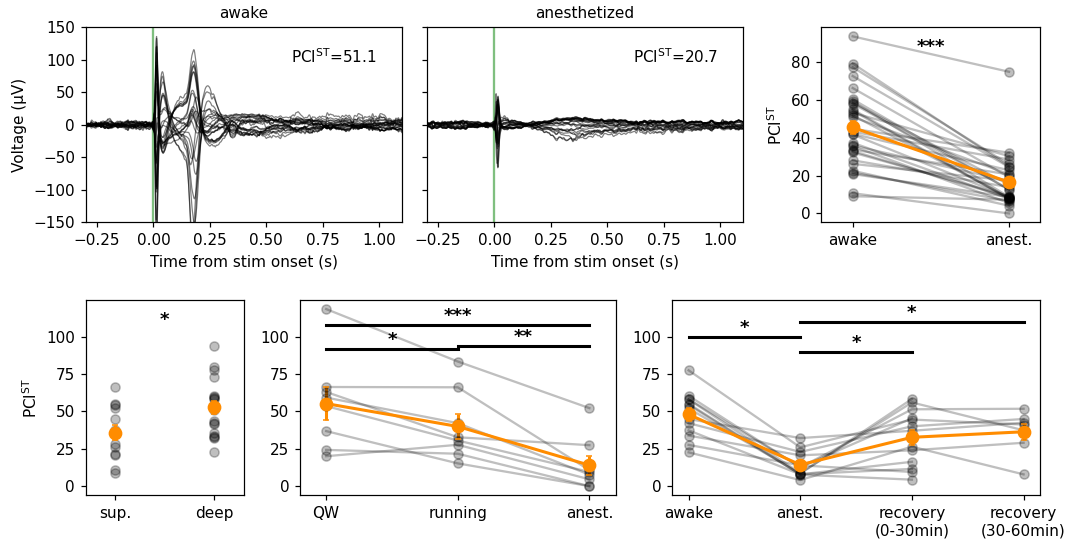

In [59]:
exgroup = 'MOs_deep'
exmouse = '571619'
plwin = [-0.3, 1.1]

fig = plt.figure(figsize=(9.75, 5))
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.08, right=0.97, top=0.95, bottom=0.1, hspace=0.4)
topgs = gs[0].subgridspec(ncols=2, nrows=1, width_ratios=[3,1], wspace=0.18)
EEGaxs = topgs[0].subgridspec(ncols=2, nrows=1, wspace=0.08).subplots(sharex=True, sharey=True)
awanPCIax = fig.add_subplot(topgs[1])
bottomgs = gs[1].subgridspec(ncols=3, nrows=1, width_ratios=[1.5,3,3.5], wspace=0.2)
sdPCIax = fig.add_subplot(bottomgs[0])
stmovPCIax = fig.add_subplot(bottomgs[1], sharey=sdPCIax)
recPCIax = fig.add_subplot(bottomgs[2], sharey=sdPCIax)


goodchs = multi_sub_dict[exgroup][exmouse]['good_chs']
EEGdata = multi_sub_dict[exgroup][exmouse]['EEG_traces']
exampledf = awake_anest_PCI_df[(awake_anest_PCI_df['group'] == exgroup) & (awake_anest_PCI_df['mouse'] == exmouse)]
numtrials = exampledf['trial_count'].values[0]

for axi, statei in zip(EEGaxs, ['awake', 'anesthetized']):
    ## Plot EEG butterfly plots ##
    traces = np.mean(EEGdata[statei][1][:, :, :numtrials], axis=2)
    timex = EEGdata[statei][0]
    exPCI = exampledf['PCI'][exampledf['state'] == statei].values[0]

    axi.axvline(0, color='g', alpha=0.5)
    axi.plot(timex, traces[:, goodchs], 'k', linewidth=0.8, alpha=0.5)
    axi.annotate(
        '$\mathregular{PCI^{ST}}$'+'={:.1f}'.format(exPCI), xy=(0.92, 0.9), xycoords='axes fraction', ha='right', va='top'
    )
    axi.set_title(statei)
    axi.set_xlabel('Time from stim onset (s)')
    
## Set titles ##
EEGaxs[0].set_ylim([-150, 150])
EEGaxs[0].set_xlim(plwin)
EEGaxs[0].set_ylabel('Voltage (\u03bcV)')
# EEGaxs[0,0].set_xticks(np.arange(timex[0], timex[-1], 0.2))

## Plot awake v anest ##
plstates = ['awake', 'anesthetized']
PCI_vals = []
for statei in plstates:
    stPCIvals = awake_anest_PCI_df['PCI'][awake_anest_PCI_df['state'] == statei].values
    PCI_vals.append(stPCIvals)
PCI_vals = np.stack(PCI_vals)
individs = awanPCIax.plot([0, 1], PCI_vals, color='k', marker='o', alpha=0.25)
mean_sem = awanPCIax.errorbar(
    [0, 1], np.mean(PCI_vals, axis=1), yerr=stats.sem(PCI_vals, axis=1), color='darkorange',
    linewidth=2, marker='o', markersize=8
)
tstat, awanpval = stats.ttest_rel(PCI_vals[0,:], PCI_vals[1,:])
# annotate with asterisk
awanPCIax.annotate(
    p_stars(awanpval), xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12, fontweight='bold', ha='center', va='center')
awanPCIax.set_ylabel('$\mathregular{PCI^{ST}}$')#, fontsize=12)
awanPCIax.set_xlim([-0.2, 1.2])
awanPCIax.set_xticks([0, 1])
awanPCIax.set_xticklabels(['awake', 'anest.'])
# awanPCIax.legend([individs[0], mean_sem], [('Individual'.format(PCI_vals.shape[1])), 'Mean +/- SEM'])

## Plot superficial vs. deep ##
compstate = 'awake'
compdepth = ['superficial', 'deep']
PCI_vals = []
for depi in compdepth:
    stPCIvals = awake_anest_PCI_df['PCI'][
        (awake_anest_PCI_df['state'] == compstate) & (awake_anest_PCI_df['stim_depth'] == depi)].values
    PCI_vals.append(stPCIvals)
for ii, (depi, vals) in enumerate(zip(compdepth, PCI_vals)):
    sdPCIax.scatter(np.repeat(ii, len(vals)), vals, color='k', marker='o', alpha=0.25)
    sdPCIax.errorbar([ii], np.mean(vals), yerr=stats.sem(vals), color='darkorange', linewidth=2, marker='o', markersize=8)
## Stats annotation ##
sdPCIax.annotate(
    p_stars(sdpval), xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12, fontweight='bold', ha='center', va='center')
sdPCIax.set_ylabel('$\mathregular{PCI^{ST}}$')# (awake)', fontsize=12)
sdPCIax.set_xlim([-0.3, 1.3])
sdPCIax.set_xticks([0, 1])
sdPCIax.set_xticklabels(['sup.', 'deep'])

## Plot stationary, moving, anesthetized ##
plstates = ['resting', 'running', 'anesthetized']
PCI_vals = []
for statei in plstates:
    stPCIvals = stat_move_anest_PCI_df['PCI'][stat_move_anest_PCI_df['state'] == statei].values
    PCI_vals.append(stPCIvals)
PCI_vals = np.stack(PCI_vals)
stmovPCIax.plot([0, 1, 2], PCI_vals, color='k', marker='o', alpha=0.25)
stmovPCIax.errorbar(
    [0, 1, 2], np.mean(PCI_vals, axis=1), yerr=stats.sem(PCI_vals, axis=1), color='darkorange',
    linewidth=2, marker='o', markersize=8
)
## annotate with stats asterisk
stmovPCIax.plot([0,1], [92,92], color='k', linewidth=2)
stmovPCIax.annotate('*', xy=(0.5,92), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
stmovPCIax.plot([1,2], [94,94], color='k', linewidth=2)
stmovPCIax.annotate('**', xy=(1.5,94), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
stmovPCIax.plot([0,2], [108,108], color='k', linewidth=2)
stmovPCIax.annotate('***', xy=(1,108), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
# stmovPCIax.set_ylabel('$\mathregular{PCI^{ST}}$')#, fontsize=12)
stmovPCIax.set_xlim([-0.2, 2.2])
stmovPCIax.set_xticks([0, 1, 2])
stmovPCIax.set_xticklabels(['QW', 'running', 'anest.'])

## Plot recovery ##
recst = ['awake', 'anesthetized', 'recovery1', 'recovery2']
for subi in np.unique(recovery_PCI_df['subject'].values):
    subPCI = recovery_PCI_df['PCI'][recovery_PCI_df['subject'] == subi].values
    recPCIax.plot(np.arange(len(subPCI)), subPCI, color='k', marker='o', alpha=0.25)
avgPCI = []
semPCI = []
for sti in recst:
    avgPCI.append(np.mean(recovery_PCI_df['PCI'][recovery_PCI_df['state'] == sti].values))
    semPCI.append(stats.sem(recovery_PCI_df['PCI'][recovery_PCI_df['state'] == sti].values))
recPCIax.errorbar([0, 1, 2, 3], avgPCI, yerr=semPCI, color='darkorange', linewidth=2, marker='o', markersize=8)
recPCIax.set_xticks([0, 1, 2, 3])
recPCIax.set_xticklabels(['awake', 'anest.', 'recovery\n(0-30min)', 'recovery\n(30-60min)'])

recPCIax.plot([0,1], [100,100], color='k', linewidth=2)
recPCIax.annotate('*', xy=(0.5,100), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
recPCIax.plot([1,2], [90,90], color='k', linewidth=2)
recPCIax.annotate('*', xy=(1.5,90), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')
recPCIax.plot([1,3], [110,110], color='k', linewidth=2)
recPCIax.annotate('*', xy=(2,110), xycoords='data', fontsize=12, fontweight='bold', ha='center', va='bottom')

## Save ##
figname = 'Fig8_PCI_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

## Save as .pdf for Illustrator ##
man_dir = os.path.dirname(plotsdir)
# fig.savefig(os.path.join(man_dir, 'AI_pdfs', figname.replace('.png', '.pdf')), transparent=True, dpi=300)

In [58]:
man_dir = os.path.dirname(plotsdir)
print(man_dir)

C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs


### Plot all subjects

### Make comparison plot